# LSTMを使用した予測モデルによるメロディ生成

## Google Colab用環境設定

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install music21

## プログラム

### 環境設定

In [0]:
import os
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import matplotlib
import matplotlib.pyplot as plt
import keras
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
work_dir = '/content/gdrive/My Drive/Colab/'

### 訓練用MIDIファイルの読み込みと前処理用関数

In [0]:
def get_notes(dir):
    notes = []

    for file in glob.glob(os.path.join(dir, '*.mid')):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

In [0]:
def prepare_sequences(notes, n_vocab, sequence_length=100):
    """ Prepare the sequences used by the Neural Network """
    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    
    # convert notes to one-hot encoded
    one_hot_notes = []
    for note in notes:
        one_hot_note = np.zeros(n_vocab)
        one_hot_note[note_to_int[note]] = 1
        one_hot_notes.append(one_hot_note)

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(one_hot_notes) - sequence_length, 1):
        sequence_in = one_hot_notes[i:i + sequence_length]
        sequence_out = one_hot_notes[i + sequence_length]
        network_input.append(sequence_in)
        network_output.append(sequence_out)

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, n_vocab))

    network_output = np.array(network_output)

    return (network_input, network_output)

### モデル作成と訓練

モデル定義

In [0]:
def create_network(network_input, n_vocab):
    model = Sequential()
    model.add(CuDNNLSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(CuDNNLSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(CuDNNLSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

    return model

In [12]:
notes = get_notes(os.path.join(work_dir, 'midi_songs'))

# get amount of pitch names
n_vocab = len(set(notes))

network_input, network_output = prepare_sequences(notes, n_vocab)
print(network_input.shape)
print(network_output.shape)

# x_train, x_test, y_train, y_test = train_test_split(network_input, network_output, test_size=0.2)

train_size = int(len(network_input) * 0.8)
x_train = network_input[:train_size]
y_train = network_output[:train_size]
x_test = network_input[train_size:]
y_test = network_output[train_size:]

model = create_network(network_input, n_vocab)

Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv786.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv785.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv784.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv783.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv782.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv781.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv780.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv779.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv778.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv777.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv776.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv775.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv774.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv773.mid
Parsing /content/gdrive/My Drive/Colab/midi_songs/bwv772.mid
(8327, 100, 124)
(8327, 124)


グラフ表示とチェックポイント保存のコールバック定義

In [0]:
class TrainingPlot(keras.callbacks.Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            clear_output(wait=True)

            N = np.arange(0, len(self.losses))

            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            #plt.style.use("seaborn")

            # Plot train loss, train acc, val loss and val acc against epochs passed
            fig,(ax1, ax2) = plt.subplots(1,2,figsize=(7,3),dpi=100,num=1)
            fig.subplots_adjust(wspace=0.35)

            ax1.plot(N, self.losses, label = "train_loss")
            ax2.plot(N, self.acc, label = "train_acc")
            ax1.plot(N, self.val_losses, label = "val_loss")
            ax2.plot(N, self.val_acc, label = "val_acc")
            ax1.set_title("Training Loss [Epoch {}]".format(epoch))
            ax2.set_title("Training Accuracy [Epoch {}]".format(epoch))
            ax1.set_xlabel("Epoch #")
            ax1.set_ylabel("Loss")
            ax2.set_xlabel("Epoch #")
            ax2.set_ylabel("Accuracy")
            ax1.legend()
            ax2.legend()
            plt.show()

filepath = os.path.join(work_dir, "weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5")
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
plot_chart = TrainingPlot()
callbacks_list = [checkpoint, plot_chart]

訓練実施

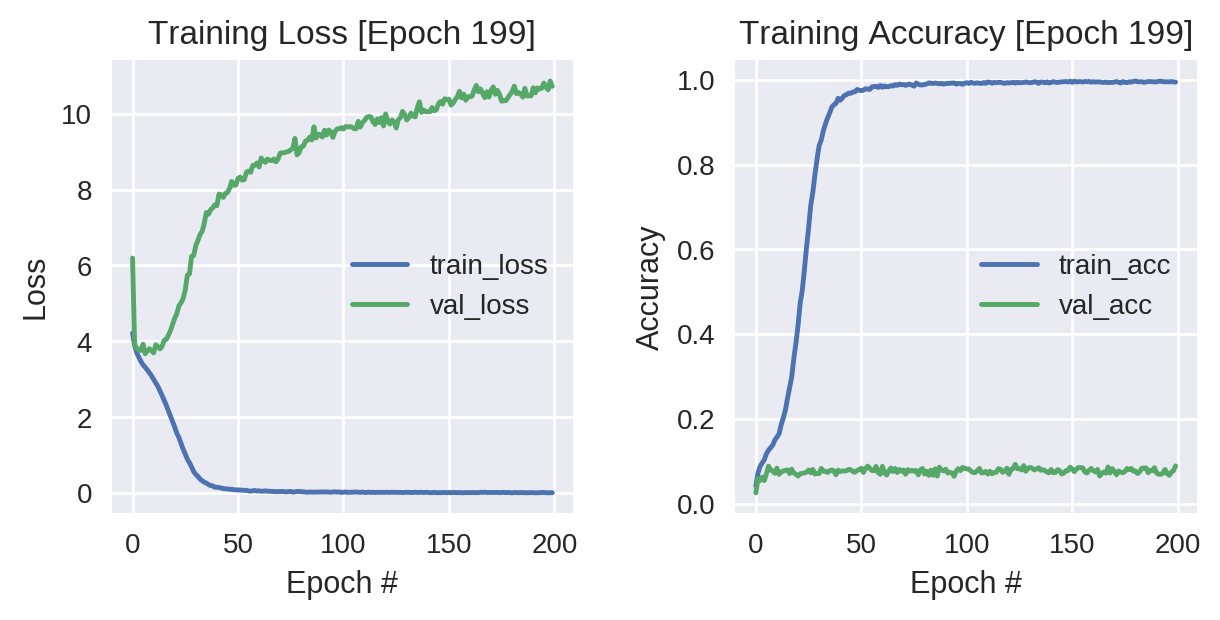

In [16]:
history = model.fit(x_train, y_train,
                                 epochs=200, 
                                 batch_size=64,
                                 validation_data=(x_test, y_test),
                                 callbacks=callbacks_list)

### メロディの生成

メロディ生成とMIDIファイル作成用関数

In [0]:
def generate_notes(model, network_input, pitchnames, n_vocab, pattern):
    """ Generate notes from the neural network based on a sequence of notes """
    
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.expand_dims(pattern, axis=0)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        index_onehot = np.zeros(n_vocab)
        index_onehot[index] = 1
        pattern = np.append(pattern, np.expand_dims(index_onehot, axis=0), axis=0)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [0]:
def create_midi(prediction_output, file_path):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=file_path)

実験１：訓練用フレーズからランダムに選択したものを初期データとしてメロディを生成

In [0]:
pitchnames = sorted(set(item for item in notes))

pattern = network_input[np.random.randint(0, len(network_input)-1)]

prediction_output = generate_notes(model, network_input, pitchnames, n_vocab, pattern)

create_midi(prediction_output, os.path.join(work_dir, 'lstm_oh_gen_test_output_2.mid'))

実験２：ランダムに生成した音素をパディングしたものを初期データとしてメロディを生成

In [0]:
from keras.utils import to_categorical

sequence_length = 100

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = np.zeros(sequence_length)
pattern[-1] = np.random.randint(1, n_vocab)
pattern = to_categorical(pattern, num_classes=n_vocab)

prediction_output = generate_notes(model, network_input, pitchnames, n_vocab, pattern)

create_midi(prediction_output, os.path.join(work_dir, 'lstm_oh_gen_test_output_rand1.mid'))